In [7]:
#%%
from dataclasses import dataclass
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from shared import (
    dataset_local_path,
    bootstrap_r2,
    simple_boxplot,
)
import random
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [8]:
# start off by seeding random number generators:
RANDOM_SEED = 12345
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Load the AirQualityUCI Dataset:
df = pd.read_csv(dataset_local_path("AirQualityUCI.csv"), sep=";", decimal=",")
print(df.shape)
# drop empty columns:
df = df.dropna(how="all", axis="columns")
print(df.shape)

PREDICT_COL = "CO(GT)"

# select only the rows where our 'y' is present:
df = df[df[PREDICT_COL] > -200.0]
print(df.shape)

# delete Date/Time columns
df.pop("Date")
df.pop("Time")

print(df.head())

(9471, 17)
(9471, 15)
(7674, 15)
   CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0     2.6       1360.0     150.0      11.9         1046.0    166.0   
1     2.0       1292.0     112.0       9.4          955.0    103.0   
2     2.2       1402.0      88.0       9.0          939.0    131.0   
3     2.2       1376.0      80.0       9.2          948.0    172.0   
4     1.6       1272.0      51.0       6.5          836.0    131.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0        1056.0    113.0        1692.0       1268.0  13.6  48.9  0.7578  
1        1174.0     92.0        1559.0        972.0  13.3  47.7  0.7255  
2        1140.0    114.0        1555.0       1074.0  11.9  54.0  0.7502  
3        1092.0    122.0        1584.0       1203.0  11.0  60.0  0.7867  
4        1205.0    116.0        1490.0       1110.0  11.2  59.6  0.7888  


In [9]:
#%%
#  Now train/test split:
tv_f, test_f = train_test_split(df, test_size=0.25, random_state=RANDOM_SEED)
train_f, vali_f = train_test_split(tv_f, test_size=0.25, random_state=RANDOM_SEED)

y_train = train_f.pop(PREDICT_COL)
y_vali = vali_f.pop(PREDICT_COL)
y_test = test_f.pop(PREDICT_COL)

In [10]:
#%%
# Now process data:
# Note, we don't NEED DictVectorizer... why?

# Let's fix missing values;
fix_missing = SimpleImputer(missing_values=-200.0)

scaler = StandardScaler()

X_train = scaler.fit_transform(fix_missing.fit_transform(train_f))
X_vali = scaler.transform(fix_missing.transform(vali_f))
X_test = scaler.transform(fix_missing.transform(test_f))

In [11]:
#%% Now let's build our models!


def regress_eval(y_true, y_pred) -> float:
    return metrics.r2_score(y_true=y_true, y_pred=y_pred)


@dataclass
class LinearRegressionModel:
    # Managed to squeeze bias into this weights array by adding some +1s.
    weights: np.ndarray

    @staticmethod
    def random(D: int) -> "LinearRegressionModel":
        weights = np.random.randn(D + 1, 1)
        return LinearRegressionModel(weights)

    def improve_feature_weight(
        self,
        train_X: np.ndarray,
        train_y: np.ndarray,
        feature_id: int,
        real_change: float = 0.0001,
    ) -> bool:
        changes = []
        start_weights = np.copy(self.weights)
        start_score = self.score(train_X, train_y)
        # try zero:
        self.weights[feature_id] = 0.0
        changes.append((self.score(train_X, train_y), np.copy(self.weights)))
        for dir in [-1, +1]:  # try bigger and smaller
            for step in [0.001, 0.01, 0.1, 1, 2, 4, 8]:  # try a range of steps
                weight = start_weights[feature_id] + dir * step
                self.weights[feature_id] = weight
                now_score = self.score(train_X, train_y)
                changes.append(
                    (now_score, np.copy(self.weights))
                )  # score accuracy/auc/whatver
        (best_score, best_weights) = max(changes, key=lambda t: t[0])
        if (best_score - start_score) >= real_change:
            self.weights = best_weights
            return True
        else:
            self.weights = start_weights
            return False

    def predict(self, X: np.ndarray) -> np.ndarray:
        """ Compute the signed distance from the self.weights hyperplane. """
        (N, D) = X.shape
        assert self.weights[:D].shape == (D, 1)
        # Matrix multiplication; sprinkle transpose and assert to get the shapes you want (or remember Linear Algebra)... or both!
        output = np.dot(self.weights[:D].transpose(), X.transpose())
        assert output.shape == (1, N)
        return (output + self.weights[-1]).reshape((N,))

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        """ Take predictions and compute accuracy. """
        y_hat = self.predict(X)
        return metrics.r2_score(np.asarray(y), y_hat)  # type:ignore


(N, D) = X_train.shape

graphs = {}

best_score = 0.0
best_model = None
for i in range(1000):
    m = LinearRegressionModel.random(D)
    train_score = m.score(X_vali, y_vali)
    if train_score > best_score or best_model is None:
        best_score = train_score
        best_model = m
        print("rand[{}] = {:.3}".format(i, train_score))

print(["{:1.3f}".format(x[0]) for x in best_model.weights.tolist()])

# graphs["Best-of-Random"] = bootstrap_r2(best_model, X_vali, y_vali)

# SGD uses derivatives to 'aim' it's search... faster than CA which explores every direction!
for i in range(20):
    sgd = SGDRegressor(random_state=i + RANDOM_SEED)
    sgd.fit(X_train, y_train)
    train_score = sgd.score(X_vali, y_vali)
    if train_score > best_score or best_model is None:
        best_score = train_score
        best_model = sgd
        print("sgd[{}] = {:.3}".format(i, train_score))

graphs["SGD"] = bootstrap_r2(best_model, X_vali, y_vali)

# Linear Regression solves for a solution to y = Ax; no randomness needed!
lr = LinearRegression()
lr.fit(X_train, y_train)
train_score = lr.score(X_vali, y_vali)
print("lr = {:.3}".format(train_score))
graphs["LR"] = bootstrap_r2(lr, X_vali, y_vali)


def ca_restart(loud=False):
    ## MINI-CA
    if loud:
        print("### Coordinate Ascent ###\n\n")
    ca = LinearRegressionModel.random(D)
    if loud:
        print("ca.start = {:.3}".format(ca.score(X_train, y_train)))
    dims = list(range(D + 1))

    # keep optimizing until we stop getting better!
    while True:
        any_better = False
        random.shuffle(dims)
        for d in dims:
            better = ca.improve_feature_weight(X_train, y_train, feature_id=d)
            if better:
                any_better = True
        if not any_better:
            break
        if loud:
            print("w+ = {:.3}".format(ca.score(X_train, y_train)))
    return ca


# Coordinate ascent; try them:
best_score = 0.0
best_model = None
for i in range(3):
    ca = ca_restart()
    train_score = ca.score(X_vali, y_vali)
    if train_score > best_score or best_model is None:
        best_score = train_score
        best_model = ca
    print("ca[{}] = {:.3}".format(i, train_score))

graphs["CoordinateAscent"] = bootstrap_r2(best_model, X_vali, y_vali)

rand[0] = -2.42
rand[4] = -1.24
rand[136] = -0.832
rand[339] = -0.0246
rand[406] = 0.164
['0.487', '0.312', '1.241', '-1.314', '-0.844', '0.131', '-0.163', '-0.857', '1.717', '-0.192', '-0.257', '0.562', '2.147']
sgd[0] = 0.901
sgd[2] = 0.901
lr = 0.9
ca[0] = 0.894
ca[1] = 0.892
ca[2] = 0.89


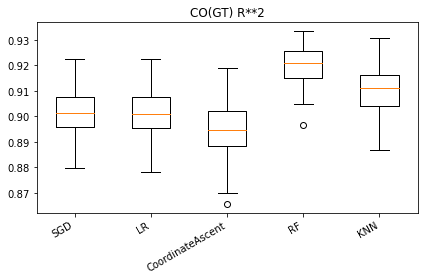

<module 'matplotlib.pyplot' from '/Users/Alderik/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [12]:
# --- now try some nonlinear models --- #
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
graphs["RF"] = bootstrap_r2(rf, X_vali, y_vali)
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
graphs["KNN"] = bootstrap_r2(knn, X_vali, y_vali)

# Graph everything:
simple_boxplot(graphs, "{} R**2".format(PREDICT_COL), save="graphs/p11-r2-score.png")


### TODO:
### 1. remove the 'best-of-random' graph, so you can see the other ones!

done

### 2. See if there's anything here that might help your project.